# Textons



纹理图像是由重复的规则或随机pattern构成的一类特殊图像。纹理描述了物体的材质。纹理基元（texton）是描述纹理的一种有效方式，是纹理图像的bag-of-visual-words模型。本次作业实现2D纹理图像中的LM texton，是[原文](https://people.eecs.berkeley.edu/~malik/papers/LM-3dtexton.pdf)算法的简化版本。CMU大学有类似的[作业](http://www.cs.cmu.edu/~nileshk/projects/TextureClassification.pdf)，可以参考。

## 数据集

我们使用[Brodatz数据集](https://sipi.usc.edu/database/database.php?volume=textures)的一部分来做实验。该部分数据和本笔记本一起发布，下载使用即可。这些图像都是单通道1024分辨率。在做分类和重构实验中，可以截取512或者256大小的子图像作为训练集和测试集。

我们使用深度学习框架里的Dataset类来描述数据集，这样可以方便在后面不同的算法里使用该数据集里的数据。

**PyTorch代码：**

In [1]:
import os
import random

import cv2  # 上面PyTorch的read_image函数无法读取tiff图像
import numpy as np
import torch
import torchvision
from sklearn.cluster import KMeans
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

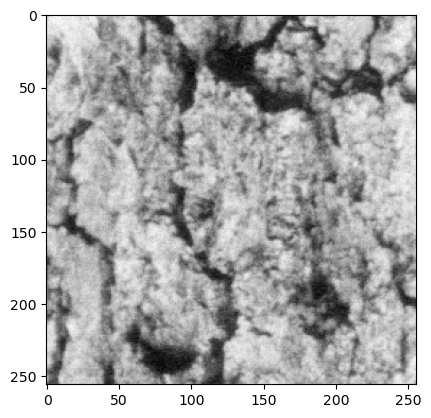

In [2]:
# 设计Brodatz数据集的Dataset类
# 使用1.3.01.tiff至1.3.13.tiff这13个纹理图像作为13个不同的类别
# 在训练深度神经网络模型时，每类需要更多的图像，我们从每类中随机裁剪出100张256*256大小的子图像作为训练或者测试使用

class BrodatzDataset(Dataset):
    # img_dir是图像文件夹，num_per_class是每类需要多少张图像，transform是图像变换
    def __init__(self, img_dir, num_per_class=10, transform=None):
        self.img_dir = img_dir
        self.num_per_class = num_per_class
        self.transform = transform
        self.img_files = [img_dir + '1.3.' + str(i).zfill(2) + '.tiff' for i in range(1, 14)]
        self.labels = []
        # 读取图像文件名，提取标签
        for img_file in self.img_files:
            label = os.path.basename(img_file).split('.')[0][-2:]
            self.labels.append(int(label) - 1)

    # 返回数据集大小
    def __len__(self):
        return self.num_per_class * 13

    # 返回第index个样本
    def __getitem__(self, index):
        # 从第index个样本中提取图像和标签
        label = index // self.num_per_class
        image1024 = cv2.imread(self.img_files[label], -1)  #.astype(np.float32)
        h, w = image1024.shape
        # image1024 = np.expand_dims(image1024, axis=0)
        x = random.randint(0, w - 256)
        y = random.randint(0, h - 256)
        image = image1024[y:y + 256, x:x + 256]
        if self.transform:
            image = self.transform(image)
        return image, label


training_dataset = BrodatzDataset(img_dir='./textures_1024/',
                                  transform=torchvision.transforms.ToTensor())
# train_dataset格式为[[image, label]]，0~99的label为0，100~199的label为1，以此类推
# image是tensor，shape为[C, H, W]，(1,256,256)

# 读取第12个样本查看
a_sample = training_dataset[12]
import matplotlib.pyplot as plt

plt.imshow(a_sample[0][0], cmap='gray')
plt.show()

## Texton

### LM filter bank

著名的牛津大学的VVG组提供了多种filter bank的[Matlab代码](https://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html)。网上有人做了[Python的实现](https://github.com/tonyjo/LM_filter_bank_python)。这份代码有bug，输出结果和Matlab的不一致，我把这个仓库fork了一份，并修正了其中的bug，给原作者提了PR。本次作业请使用我修改后的[Python代码](https://github.com/qilin512/LM_filter_bank_python/blob/master/lm.py)（我只修改了lm.py文件）。

输出的F矩阵（3维数组）包含了48个滤波器，每个都是49*49。

在Texton实验中，filter bank的作用是从图像中提取特征。Filter bank是一组滤波器，每个滤波器都可以检测图像中的不同方向、频率和相位的特征。通过使用一组不同的滤波器，可以捕获图像中的多个特征，从而提高对图像的描述和分类的准确性。

在Texton实验中，filter bank是用来提取图像中的Texton特征的。Texton是一种基本的图像单元，类似于局部纹理块，可以通过在图像中使用filter bank来检测。通过提取图像中的Texton特征，可以将图像进行编码和分类，可以用于图像检索、目标检测和图像分类等应用。因此，filter bank在Texton实验中是非常重要的。


In [3]:
# 使用我修改后的代码构造filter bank
# 可以把相关的代码拷贝过来，或者把该Python文件加入到工程中，作为jupyter笔记本调用的外部程序。
'''
The Leung-Malik (LM) Filter Bank, implementation in python

T. Leung and J. Malik. Representing and recognizing the visual appearance of
materials using three-dimensional textons. International Journal of Computer
Vision, 43(1):29-44, June 2001.

Reference: http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
'''


def gaussian1d(sigma, mean, x, ord):
    x = np.array(x)
    x_ = x - mean
    var = sigma ** 2
    # Gaussian Function
    g1 = (1 / np.sqrt(2 * np.pi * var)) * (np.exp((-1 * x_ * x_) / (2 * var)))
    if ord == 0:
        g = g1
        return g
    elif ord == 1:
        g = -g1 * (x_ / var)
        return g
    else:
        g = g1 * (((x_ * x_) - var) / (var ** 2))
        return g


def gaussian2d(sup, scales):
    var = scales * scales
    shape = (sup, sup)
    n, m = [(i - 1) / 2 for i in shape]
    x, y = np.ogrid[-m:m + 1, -n:n + 1]
    g = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x * x + y * y) / (2 * var))
    return g


def log2d(sup, scales):
    var = scales * scales
    shape = (sup, sup)
    n, m = [(i - 1) / 2 for i in shape]
    x, y = np.ogrid[-m:m + 1, -n:n + 1]
    g = (1 / np.sqrt(2 * np.pi * var)) * np.exp(-(x * x + y * y) / (2 * var))
    h = g * ((x * x + y * y) - var) / (var ** 2)
    return h


def normalise(f):
    f = f - np.mean(f)
    f = f / np.sum(np.abs(f))
    return f


def makefilter(scale, phasex, phasey, pts, sup):
    gx = gaussian1d(3 * scale, 0, pts[0, ...], phasex)
    gy = gaussian1d(scale, 0, pts[1, ...], phasey)
    f = gx * gy
    f = np.reshape(f, (sup, sup))
    f = normalise(f)
    return f


def makeLMfilters():
    # 滤波器大小
    sup = 49
    # 方向数
    scalex = np.sqrt(2) ** np.array([1, 2, 3])
    # 频率数
    norient = 6
    nrotinv = 12
    nbar = len(scalex) * norient
    nedge = len(scalex) * norient
    nf = nbar + nedge + nrotinv
    F = np.zeros([sup, sup, nf])
    hsup = (sup - 1) / 2
    x = [np.arange(-hsup, hsup + 1)]
    # y = [np.arange(-hsup,hsup+1)]
    y = [np.arange(hsup, -hsup - 1, -1)]
    [x, y] = np.meshgrid(x, y)
    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    count = 0
    # 水平方向的滤波器
    for scale in range(len(scalex)):
        for orient in range(norient):
            angle = (np.pi * orient) / norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotmtx = np.array([[c, -s], [s, c]])
            rotpts = np.dot(rotmtx, orgpts)
            F[:, :, count] = makefilter(scalex[scale], 0, 1, rotpts, sup)
            F[:, :, count + nedge] = makefilter(scalex[scale], 0, 2, rotpts, sup)
            count = count + 1
    # 对角线方向的滤波器
    count = nbar + nedge
    scales = np.sqrt(2) ** np.array([1, 2, 3, 4])
    for i in range(len(scales)):
        F[:, :, count] = gaussian2d(sup, scales[i])
        F[:, :, count + 1] = log2d(sup, scales[i])
        F[:, :, count + 2] = log2d(sup, 3 * scales[i])
        count = count + 3
    return F


# F为滤波器组，大小为49x49，一共48个滤波器
F = makeLMfilters()
print(F.shape)

(49, 49, 48)


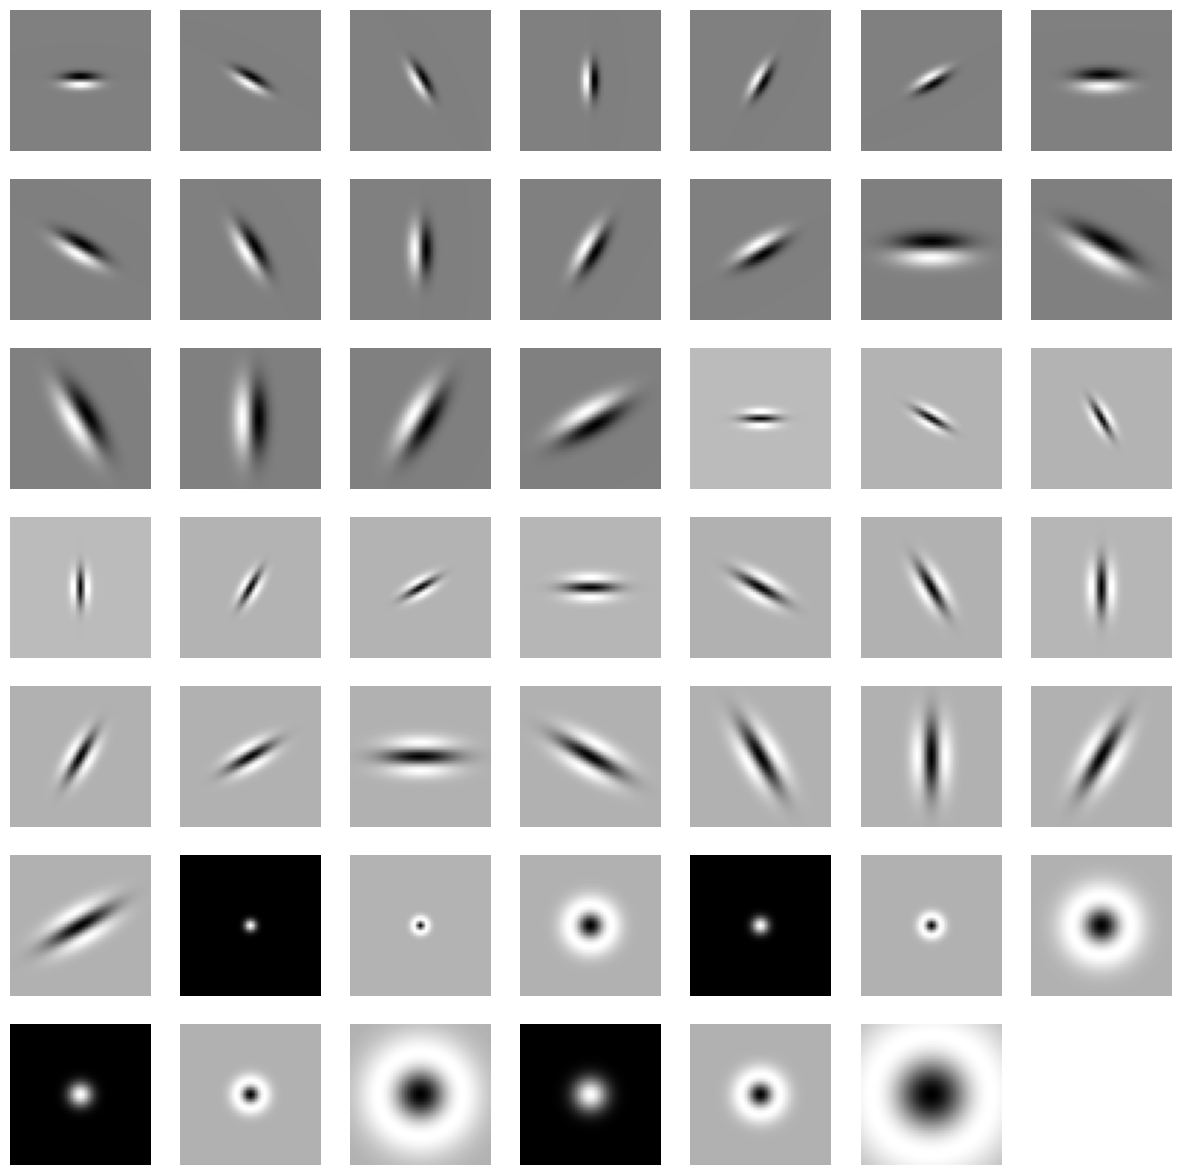

In [106]:
# 可视化filter bank
def show_filter_bank(filter_bank):
    plt.figure(figsize=(15, 15))
    for i in range(48):
        plt.subplot(7, 7, i + 1)
        plt.imshow(filter_bank[:, :, i], cmap='gray')
        plt.axis('off')
    plt.show()
show_filter_bank(F)

### 基于滤波器响应的纹理图像分类

使用filter bank对图像进行滤波，滤波后的结果图像可以称为“特征图”（feature map），假设滤波器个数为C，每个图像将产生C个特征图。特征图的元素个数还是很多，为了得到更简洁的表示，我们计算每个特征图的均值和方差，作为该特征图的特征向量。因此可以得到元素个数为2C的特征向量，用这个特征向量表示这幅图像。

然后就可以使用机器学习算法对图像进行分类任务。这里先使用K-最近邻算法（K-Nearest Neighbourhood，KNN）。关于KNN算法，可以参考这个[知乎文章](https://zhuanlan.zhihu.com/p/25994179)或者这个[英文教程](https://www.tutorialspoint.com/machine_learning_with_python/machine_learning_with_python_knn_algorithm_finding_nearest_neighbors.htm)进行学习。

scikit库里有个使用Garbor filters进行纹理分类的[例子](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html)，有一点相似的地方，可以参考。

为了衡量分类算法的性能，需要把划分训练集和测试集（有时还需要验证集，比如为了选定KNN里距离函数）。请你先返回上面“数据集”一节的代码，修改为两个类，一个是train另一个是test，一般test数据集的大小相比train数据集要小得多。在train数据集上形成KNN，在test数据集上测试，看看分类的正确率有多少，即test数据集里分类正确的数据个数占test数据集总个数的百分比。

In [5]:
# TODO 使用特征图的简单统计特征（均值和方差）对图像进行分类
# 根据tensor格式图片计算均值、方差
def calculate_mean_std(tensor_img):
    # 求每个通道的均值和标准差
    mean = torch.mean(tensor_img, dim=(1, 2))
    std = torch.std(tensor_img, dim=(1, 2))
    # 合并成特征向量
    feature_vector = torch.cat((mean, std * std), dim=0)
    return feature_vector

In [27]:
import torch.nn as nn
# 传入数据集以及filter bank，返回特征图列表

# 使用48个滤波器对130张图片进行滤波，得到130x48=6240个特征图
def get_feature_map(dataset, F):
    feature_maps = []
    # 定义卷积层
    conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(49, 49))
    for i in range(len(dataset)):
        for j in range(48):
            # 放到GPU上
            training_image = dataset[i][0].to(device)
            # 转换成1x256x256(图片在这一步会变为256x256，需reshape为3d)
            training_image = training_image.reshape(1, 256, 256)
            # 读取第j个滤波器
            conv_layer.weight.data = torch.Tensor(F[:,:,j].reshape(1, 1, 49, 49))
            conv_layer.to(device)
            # 卷积
            conv_result = conv_layer(training_image)
            feature_maps.append(conv_result)
    return feature_maps
feature_maps = get_feature_map(training_dataset, F)

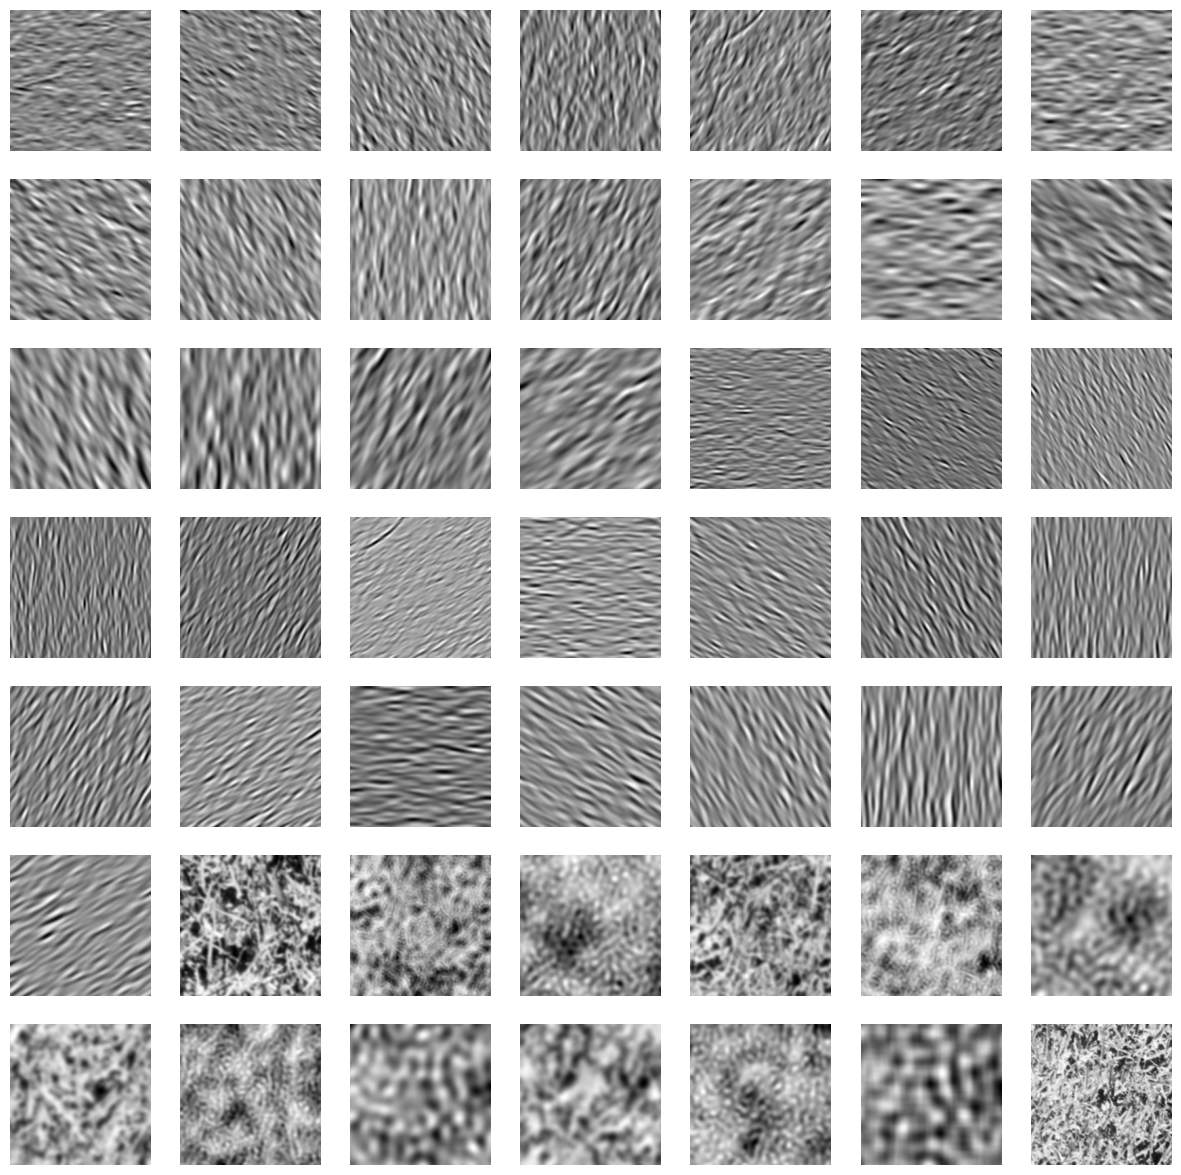

In [105]:
# 查看特征图效果，最后一张为原图
plt.figure(figsize=(15, 15))
for i in range(48):
    plt.subplot(7, 7, i + 1)
    plt.imshow(feature_maps[i][0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.subplot(7,7,49)
plt.imshow(training_dataset[0][0][0],cmap='gray')
plt.axis('off')
plt.show()

In [33]:
feature_maps_tensor = torch.stack(feature_maps).reshape(130,48,208,208)
print(feature_maps_tensor.shape)

torch.Size([130, 48, 208, 208])


In [35]:
# 传入特征图列表，返回特征向量列表
def get_feature_vector(feature_maps_tensor):
    feature_vectors = np.zeros((feature_maps_tensor.shape[0],2*feature_maps_tensor.shape[1]))
    for i, feature in enumerate(feature_maps_tensor):
        for j in range(feature_maps_tensor.shape[1]):
            feature_vectors[i][2*j:2*j+2] = [feature[j].cpu().detach().numpy().mean(),feature[j].cpu().detach().numpy().var()]
    return feature_vectors

feature_vectors = get_feature_vector(feature_maps_tensor)
print(feature_vectors.shape)

(130, 96)


In [39]:
train_labels = []
# 生成训练集标签
for label in training_dataset:
    train_labels.append(label[1])
len(train_labels)

130

In [41]:
# 导入训练集与测试集拆分模块
from sklearn.model_selection import train_test_split
# 按3:7拆,用4个变量进行接收数据，以免数据分割后被直接释放
x_train, x_test, y_train, y_test = train_test_split(feature_vectors, train_labels, test_size=0.3, random_state=2)

In [44]:
from sklearn.neighbors import KNeighborsClassifier


def knn_classification(x_train, x_test, y_train, y_test, n_neighbors=7):
    # 创建KNN分类器对象
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    # 使用训练集训练KNN分类器
    knn_clf.fit(x_train, y_train)
    print('train_accuracy:', knn_clf.score(x_train, y_train), '\n test_accuracy:', knn_clf.score(x_test, y_test))


knn_classification(x_train, x_test, y_train, y_test)

train_accuracy: 0.8901098901098901 
 test_accuracy: 0.7435897435897436


E:\ANACONDA3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
E:\ANACONDA3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

E:\ANACONDA3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
E:\ANACONDA3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to a

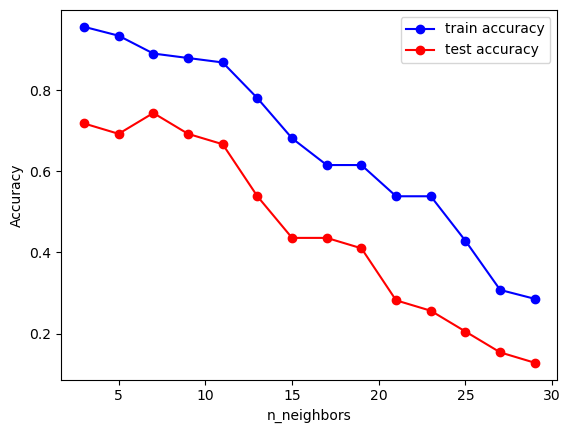

In [45]:
from sklearn import neighbors

train_accuracy = []
test_accuracy = []
# 尝试n_neighbors从3到30的奇数
neighbors_settings = range(3, 30,2)
for n_neighbors in neighbors_settings:
    # 创建模型
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(x_train, y_train)
    # 记录训练accuracy
    train_accuracy.append(knn_clf.score(x_train, y_train))
    # 记录测试accuracy
    test_accuracy.append(knn_clf.score(x_test, y_test))

# 可视化
plt.plot(neighbors_settings, train_accuracy, 'bo-', label="train accuracy")
plt.plot(neighbors_settings, test_accuracy, 'ro-', label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

### 生成textons

通过上面的实验可以发现，分类效果并不好，很大一部分原因是因为仅使用feature map的均值和方差并不能很好的表征纹理图像，一幅图像或者其feature map包含很多信息，而仅使用feature map的两种统计量（均值和方差都是一阶矩）是不够的。

这里我们就要借鉴这篇[论文](https://people.eecs.berkeley.edu/~malik/papers/LM-3dtexton.pdf)中的方法了。使用LM filter bank对纹理图像进行滤波，在feature map的基础上生成Texton，然后使用texton完成分类任务。具体地，针对一幅纹理图像（大小为$H\times W$），使用filter bank进行滤波（假设滤波器个数为C），得到$H \times W \times C$的特征图。每个像素对应一个C维的特征向量。针对这$H \times W$个特征向量进行K-means聚类，设置聚类类别数比如K=20。这K个聚类中心即称为该纹理图像的appearance vector。这种算法是稀疏编码在纹理图像上的应用，对应着bag-of-words模型里的字典。

K-means算法可以通过[这篇知乎文章](https://zhuanlan.zhihu.com/p/20432322)或者[这篇英文教程](https://realpython.com/k-means-clustering-python/)进行学习。

下面需要使用代码实现。

In [64]:
# TODO 使用K-means实现一幅纹理图像的滤波响应向量聚类
# 1. 将特征图reshape为H*W行，C列的矩阵，每一行是一个C维的特征向量
# 针对一张图片返回一个48列，H*W行的numpy数组
def reshape_feature_map(feature_maps_tensor):
    # 获取每个元素的高度和宽度
    c, h, w = feature_maps_tensor.shape
    # 初始化一个空的数组
    reshaped = np.zeros((h * w, c))
    flag = 0
    for i in range(h):
        for j in range(w):
            reshaped[flag] = feature_maps_tensor.cpu().detach().numpy()[:,i,j]
            flag+=1
    return reshaped

In [62]:
# texton分类数据集拆分
x_train, x_test, y_train, y_test = train_test_split(feature_maps_tensor.cpu(), train_labels, test_size=0.3, random_state=2)
print("训练集大小",x_train.shape)
print("测试集大小",x_test.shape)

训练集大小 torch.Size([91, 48, 208, 208])
测试集大小 torch.Size([39, 48, 208, 208])


In [65]:
# 2. 使用K-means对特征向量进行聚类，得到聚类中心，即appearance vector
# 单个H*WxC向量
def kmeans_clustering(num_clusters):
    # 创建KMeans聚类器
    kmeans = KMeans(n_clusters=num_clusters)
    # 训练聚类器并得到聚类中心
    appearance_vector = np.zeros((13,num_clusters,x_train.shape[1]))
    for i in range(13):
        # 数据集为37分，每类10张，因此测试集为10*0.7=7
        feature_map =  x_train[i*7]
        reshaped = reshape_feature_map(feature_map)
        kmeans.fit(reshaped)
        appearance_vector[i] = kmeans.cluster_centers_
    return appearance_vector

# 3. 返回appearance vector
appearance_vector = kmeans_clustering(20)

In [66]:
print(appearance_vector.shape)

(13, 20, 48)


### 基于texton的纹理分类

如果做纹理分类任务，将数据集中的所有纹理图像都进行上述处理，每个图像都产生K个聚类中心（texton），该向量称为appearance vector。所有图像的texton放在一起，再按距离把相似的进行合并（这一步可选），最终得到Q个texton。这样，每个图像的每个像素属于哪个texton是可追溯的，能得到一幅或者一类图像在这Q个texton上的频率分布（直方图）。在推断的时候，给定一幅纹理图像，还是用这个filter bank滤波后，每个像素对应的特征向量和Q个texton计算距离，选择距离最近的作为其对应的texton，从而获得该图像在Q个texton上的分布直方图。将该直方图和训练集中的每类对应的直方图计算卡方距离（$\chi^2$ distance），即能进行分类。

In [ ]:
from scipy.spatial.distance import cdist

# 计算欧几里得距离
def calculate_euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# 合并相似的texton
def merge_similar_textons(texton_list, threshold):
    merged_textons = [texton_list[0]]
    for texton in texton_list[1:]:
        min_distance = float('inf')
        closest_texton = None
        for merged_texton in merged_textons:
            distance = calculate_euclidean_distance(texton, merged_texton)
            if distance < min_distance:
                min_distance = distance
                closest_texton = merged_texton
        # 如果最小距离小于阈值，则合并
        if min_distance < threshold:
            merged_textons = [x for x in merged_textons if x != closest_texton]
            merged_textons.append((texton + closest_texton) / 2)
        # 否则，不合并
        else:
            merged_textons.append(texton)
    return merged_textons

# 计算卡方距离
def calculate_chi_square_distance(sample_texton, q_textons, trained_histograms):
    # 计算样本的texton直方图
    q_textons_1d = np.concatenate(q_textons, axis=0)
    # 将texton展开为一列
    sample_texton_2d = sample_texton.reshape(len(sample_texton), -1)
    # 计算每个像素到Q个texton的距离
    distances = cdist(sample_texton_2d, q_textons_1d)
    # 找到距离最近的texton
    closest_texton_indices = np.argmin(distances, axis=0)
    # 计算直方图
    sample_histogram = np.histogram(closest_texton_indices, bins=len(q_textons_1d), range=(0, len(q_textons_1d)))[0]
    # 计算卡方距离
    min_chi_square_distance = float('inf')
    best_match_label = None
    # 对每个类别的直方图计算卡方距离
    for label, histograms in trained_histograms.items():
        for histogram in histograms:
            chi_square_distance = 0.5 * np.sum(
                ((histogram - sample_histogram) ** 2) / (histogram + sample_histogram + 1e-6))
            # 选择距离最小的类别
            if chi_square_distance < min_chi_square_distance:
                min_chi_square_distance = chi_square_distance
                best_match_label = label
    return best_match_label

In [69]:
# 计算单个样本的texton直方图
def calculate_texton_histogram(feature_map, label, q_textons):
    n_textons = q_textons.shape[1]
    histogram = np.zeros(n_textons)

    # 遍历所有像素，计算最近的texton并更新直方图
    for i in range(feature_map.shape[1]):
        for j in range(feature_map.shape[2]):
            pixel = feature_map[:, i, j]
            distances = np.linalg.norm(pixel - q_textons[label], axis=0)
            closest_texton = np.argmin(distances)
            histogram[closest_texton] += 1

    # 归一化直方图
    histogram /= sum(histogram)

    return histogram

# 计算所有样本的texton直方图
def calculate_all_texton_histograms(x_train, q_textons, per_class=7):
    n_classes = x_train.shape[0] // per_class
    all_texton_histograms = np.zeros((n_classes, q_textons.shape[1]))

    # 遍历所有样本，计算每个类别的texton直方图并累加
    for i in range(x_train.shape[0]):
        class_index = i // per_class
        all_texton_histograms[class_index] += calculate_texton_histogram(x_train[i], class_index, q_textons)

    # 归一化直方图
    all_texton_histograms /= sum(all_texton_histograms[0])

    return all_texton_histograms

# 计算所有图像texton直方图
all_texton_histogram = calculate_all_texton_histograms(x_train, appearance_vector, 7)

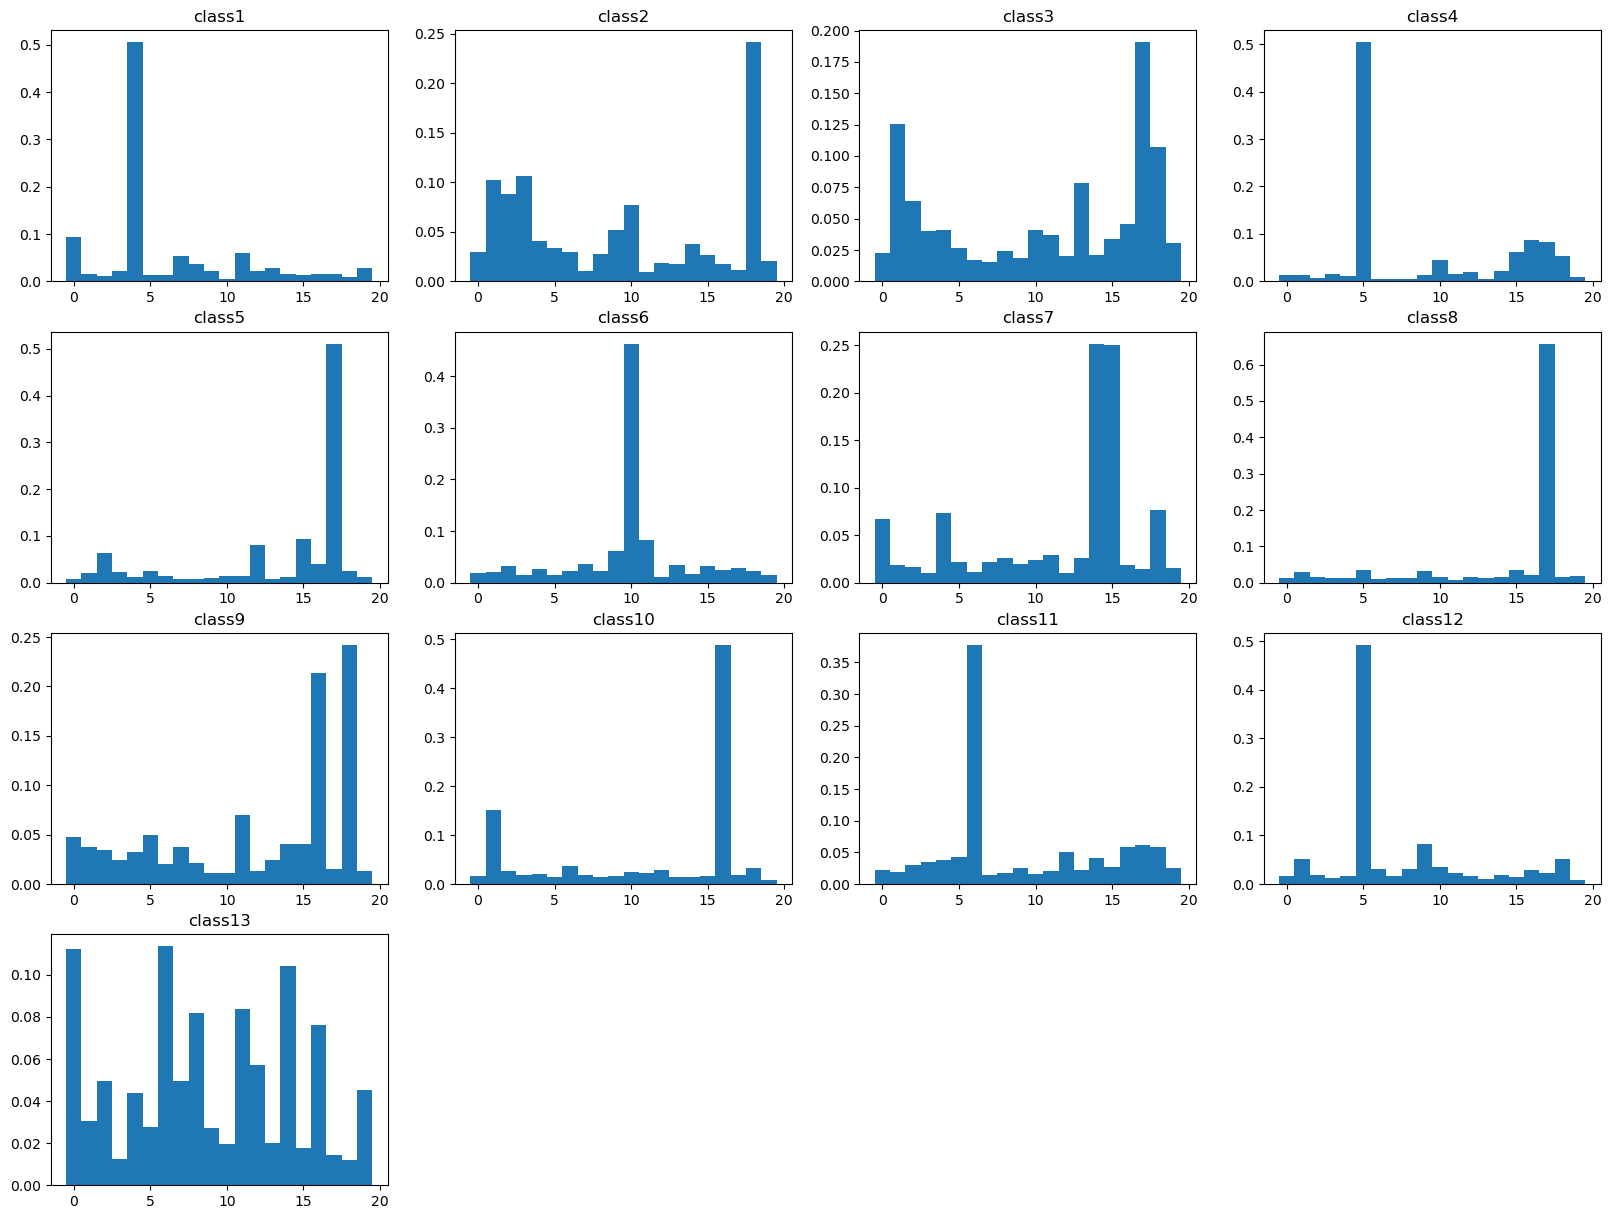

In [103]:
# 可视化
flag = 0
plt.figure(figsize=(20,15))
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,flag+1)
        plt.title(f"class{flag+1}")
        plt.bar(x=range(20),height=all_texton_histogram[flag],width=1)
        flag+=1
        if flag == 13:
            break

In [72]:
# 计算单个样本的分类结果
def classify_sample(feature, textons, all_texton_histograms):
    # 获取样本的形状
    c, h, w = feature.shape

    # 初始化距离和输出类别
    distance = float('inf')
    out_class = -1

    # 遍历所有类别，计算每个类别的直方图距离
    for i, ref_histogram in enumerate(all_texton_histograms):
        histogram = calculate_all_texton_histograms(feature, i, textons)
        # 检查直方图是否归一化
        assert abs(ref_histogram.sum() - 1) < 1e-3 and abs(histogram.sum() - 1) < 1e-3
        # 计算直方图距离
        dist = cv2.compareHist(ref_histogram, histogram, cv2.HISTCMP_CHISQR)
        # 更新最小距离和输出类别
        if dist < distance:
            distance = dist
            out_class = i

    return out_class

# 对测试集中的所有样本进行分类
pre_class = np.zeros(x_test.shape[0])
for i, feature in enumerate(x_test):
    pre_class[i] = classify_sample(feature, appearance_vector, all_texton_histogram)

# 计算分类准确率
score = sum(np.repeat(range(13), 2) == pre_class) / len(pre_class)
print("text上正确率", 100 * score, "%")

测试集上正确率为93.3477%


### 基于texton的纹理重建

输入：一幅纹理图像

目标：对这幅图像构建的texton字典，利用texton重构该图像。

原理：图像的每个像素都对应一个texton，可以通过其对应的appearance vector求滤波器的最小二乘下的输入是什么样子的。

具体的做法在上面的论文中有详细描述：

1. 计算滤波器矩阵的伪逆。将每个滤波器都拉成一个行向量，C个滤波器构成一个新的F矩阵（$HW \times C$），求这个矩阵的伪逆$F^+$。
2. $F^+$与每个texton的appearance vector相乘，得到每个texton对应的重构patch。根据原图像的每个像素值对应的texton，找到对应的重构patch（记得是把得到的向量reshape成滤波器大小的patch），将该patch的中心元素作为重构图像的该像素的像素值。

要求达到类似原文Figure 5所展示的效果，注意，选用的纹理图像不一样，效果会有区别。

In [84]:
# 重构任务代码
from skimage import io
# texton为130张图片经过48个49*49滤波器，K=20聚类得到的130个(48,20)的矩阵
# F+为(49*49,48)的矩阵，即(2401,48)

def crop_image(img, size=(256, 256)):
    # 裁剪图像为给定的尺寸
    h, w, c = img.shape
    y_start = (h - size[0]) // 2
    x_start = (w - size[1]) // 2
    return img[y_start:y_start + size[0], x_start:x_start + size[1]]


def create_filter_matrix(filter_bank):
    # 将filter bank重构为滤波器矩阵
    filter_size, _, num_filters = filter_bank.shape
    F = filter_bank.reshape(num_filters, -1).T
    return F


def compute_pseudoinverse(F):
    # 计算滤波器矩阵的伪逆
    # F_plus为(48,2401)
    F_plus = np.linalg.pinv(F)
    return F_plus


def reconstruct_patches(F_plus, appearance_vectors):
    # 从appearance向量重构patch
    patches = np.matmul(F_plus.reshape(2401, 48), appearance_vectors)
    patch_size = int(np.sqrt(patches.shape[0]))
    return patches.reshape(-1, patch_size, patch_size)


def reconstruct_image(img, texton_indices, patches):
    # 重建图像
    h, w, _ = img.shape
    recon_img = np.zeros((h, w))
    for i in range(h):
        for j in range(w):
            texton_id = texton_indices[i, j]
            patch = patches[texton_id]
            recon_img[i, j] = patch[patch.shape[0] // 2, patch.shape[1] // 2]
    return recon_img


def texture_reconstruction(image_path, filter_bank, appearance_vectors, texton_indices):
    # 读取和裁剪图像
    # img = read_image(image_path)
    img = cv2.imread(image_path)
    cropped_img = crop_image(img)
    # 创建滤波器矩阵并计算伪逆
    F = create_filter_matrix(filter_bank)
    F_plus = compute_pseudoinverse(F)
    # 重构patch并重建图像
    patches = reconstruct_patches(F_plus, appearance_vectors)
    recon_img = reconstruct_image(cropped_img, texton_indices, patches)

    return recon_img

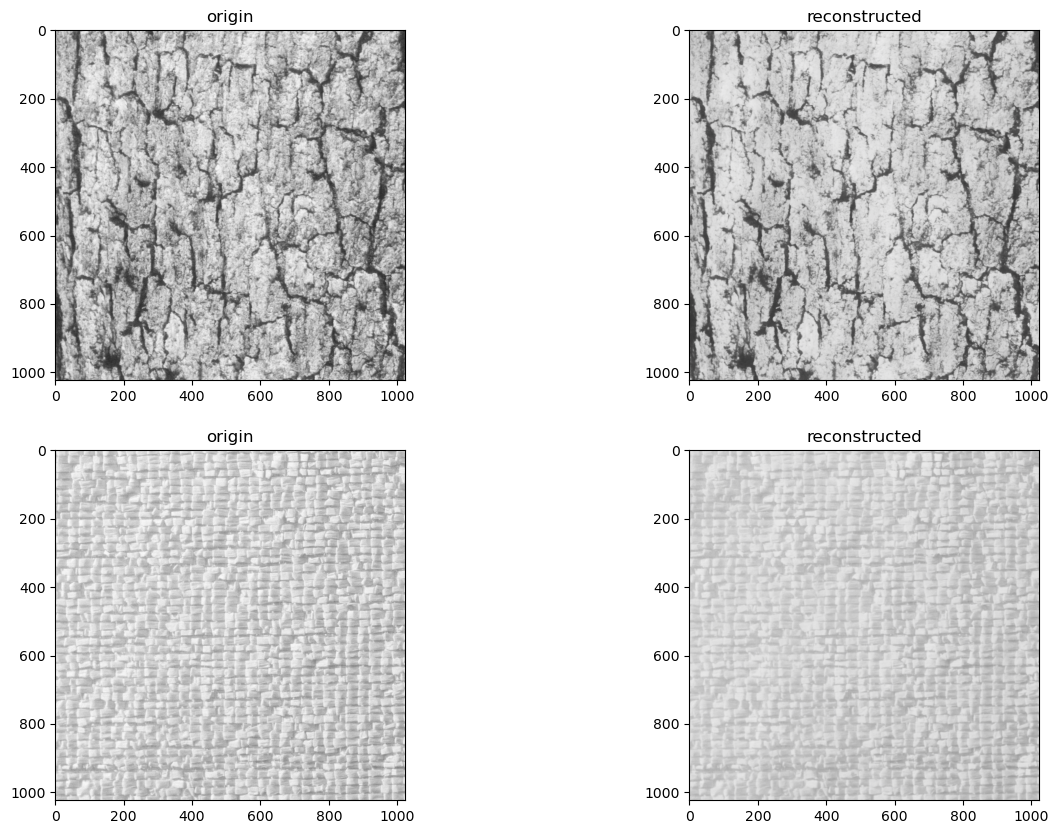

In [102]:
filter_bank = makeLMfilters()
# 对于裁剪后的256x256图像，随机生成texton indices
texton_indices = np.random.randint(0, 20, (256, 256))

# 调用texture_reconstruction函数进行纹理重建
image_path1 = "./textures_1024/1.3.02.tiff"
image_path2 = "./textures_1024/1.3.10.tiff"
reconstructed_image1 = texture_reconstruction(image_path1, filter_bank, appearance_vector, texton_indices)
reconstructed_image2 = texture_reconstruction(image_path2, filter_bank, appearance_vector, texton_indices)

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title("origin")
plt.imshow(image_path1)
plt.subplot(2,2,2)
plt.title("reconstructed")
plt.imshow(reconstructed_image1)
plt.subplot(2,2,3)
plt.title("origin")
plt.imshow(image_path2)
plt.subplot(2,2,4)
plt.title("reconstructed")
plt.imshow(reconstructed_image2)

## 可学习的特征

filter bank设计得很巧妙，是学者的脑力贡献，如何运用filter bank提取的丰富特征？我们前面用过统计特征（均值和方差）和texton（聚类pooling）。如果能从数据中学习到参数，岂不是更好？最后让我们借鉴深度学习里的CNN（convolutional neural network）。2016年PR Letter上有篇文章[Using filter banks in Convolutional Neural Networks for texture classification](https://www.semanticscholar.org/paper/Using-filter-banks-in-Convolutional-Neural-Networks-Andrearczyk-Whelan/988b4683dfb0566cf862f37d9e452d94d0bed916)，设计了2层CNN，后接几个FC层，进行了纹理分类任务，这篇工作的网络模型非常简单，但是对数据集的收集和实验做的比较好，值得分享。

请设计一个两层的CNN网络，第一个卷积层设置为我们的filter bank：48个卷积核（滤波器），大小为$49 \times 49$（够大核的）。第二层卷积层的卷积核个数为类别数，大小为$1 \times 1$。网络的第三层为global average pooling层(GAP层)。最后接softmax输出类别概率。

第一层卷积层因为使用设计好的filter bank，所以需要加载现成的参数，相当于预训练的部分模型参数。

实验分两部分。第一部分实验freeze第一个卷积层，只学习第二个卷积层。第二部分实验学习网络的全部参数，相当于对filter bank进行微调fine tuning。对比一下两个部分的分类效果，并把第二部分的微调后的第一个卷积层的滤波器保存并可视化出来，看看和学者们设计的滤波器相比有什么变化。

In [108]:
import torch
import torch.nn as nn


class FilterBankCNN(nn.Module):
    def __init__(self, num_classes, filter_bank):
        super(FilterBankCNN, self).__init__()
        self.num_classes = num_classes
        # 第一个卷积层，使用预训练的filter bank
        self.conv1 = nn.Conv2d(1, 48, kernel_size=49, stride=1, padding=0, bias=False)
        self.conv1.weight.data = torch.nn.Parameter(filter_bank)
        # 第二个卷积层
        self.conv2 = nn.Conv2d(48, num_classes, kernel_size=1)
        # GAP层
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # softmax层
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # 第一层卷积
        x = self.conv1(x)
        # 第二层卷积
        x = self.conv2(x)
        # GAP层
        x = self.global_avg_pool(x)
        # 变形
        x = x.view(-1, self.num_classes)
        # softmax层
        x = self.softmax(x)
        return x

### 定义名为 FilterBankCNN 的 nn.Module 类，该类实现了上述要求的CNN网络

*num_classes*：指定类别数，即输出层的神经元数量。
*filter_bank*：预训练的*filter bank*，类型为*torch.Tensor*，shape为(48, 1, H, W)。
*self.conv1*：第一个卷积层，输入通道数为1，输出通道数为48，卷积核大小为*filter_bank*的大小，不使用偏置。
*self.conv2*：第二个卷积层，输入通道数为48，输出通道数为*num_classes*，卷积核大小为1。
*self.global_avg_pool*：全局平均池化层，将最后一个卷积层的输出进行平均池化，输出大小为(1, 1)。
*self.softmax*：softmax层，用于输出每个类别的概率。
*forward*方法：前向传播函数，实现了上述网络结构的前向计算过程。


In [109]:
from torch.utils.data import Dataset, DataLoader

# 定义数据集类
class MyDataset(Dataset):
    # 初始化
    def __init__(self, data):
        self.data = data
    # 返回数据集大小
    def __len__(self):
        return len(self.data)
    # 获取数据集中的一条数据
    def __getitem__(self, index):
        image, label = self.data[index]
        return image, label

In [110]:
# 转换数据集为PyTorch数据集
train_dataset = MyDataset(training_dataset)

# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [111]:
from torch import optim

# 定义模型
filter_bank = makeLMfilters()
# 将filter bank转换为Tensor
filter_tensor = torch.from_numpy(filter_bank.transpose((2, 0, 1))).unsqueeze(1).float()
# 创建模型
model = FilterBankCNN(num_classes=13, filter_bank=filter_tensor)

# 冻结第一个卷积层的参数
for param in model.conv1.parameters():
    param.requires_grad = False

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.conv2.parameters(), lr=0.01, momentum=0.5)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    total = 0
    # 训练模型
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 统计训练损失
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        train_correct += (predicted == target).sum().item()
    # 打印训练过程的信息
    print('Epoch: %d, Loss: %.3f, Accuracy: %.3f %%' % (
    epoch + 1, train_loss / len(train_loader), 100.0 * train_correct / total))

Epoch: 1, Loss: 2.564, Accuracy: 6.154 %
Epoch: 2, Loss: 2.563, Accuracy: 7.692 %
Epoch: 3, Loss: 2.562, Accuracy: 7.692 %
Epoch: 4, Loss: 2.562, Accuracy: 7.692 %
Epoch: 5, Loss: 2.562, Accuracy: 7.692 %
Epoch: 6, Loss: 2.561, Accuracy: 7.692 %
Epoch: 7, Loss: 2.561, Accuracy: 7.692 %
Epoch: 8, Loss: 2.560, Accuracy: 7.692 %
Epoch: 9, Loss: 2.561, Accuracy: 7.692 %
Epoch: 10, Loss: 2.563, Accuracy: 7.692 %


### train以上代码实现了第一部分的实验。具体解释如下：

*datasets.CIFAR10*：使用PyTorch内置的CIFAR-10数据集。
*transforms*：数据预处理，将彩色图像转为灰度图像，并进行归一化。
model ：使用上述定义的*FilterBankCNN*类定义CNN模型。
*for param in model.conv1.parameters(): param.requires_grad = False*：将第一个卷积层的参数设置为不可训练，即冻结该层。
*nn.CrossEntropyLoss()*：定义交叉熵损失函数。
- *optim.SGD(model.conv2.parameters(), lr=0.01, momentum=0.5)*：定义随机梯度下降优化器，只优化第二个卷积层的参数。
- *for epoch in range(num_epochs):*：训练模型，每个epoch遍历数据集一次。
- *optimizer.zero_grad()*：梯度清零。
- *output = model(data)*：前向传播。
- *loss = criterion(output, target)*：计算损失。
- *loss.backward()*：反向传播求梯度。
- *optimizer.step()*：更新参数。
- *train_loss*、*train_correct*、*total*：统计训练损失、正确率和样本数量。

In [112]:
# 定义数据加载器
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# 定义模型
filter_bank = makeLMfilters()
filter_tensor = torch.from_numpy(filter_bank.transpose((2, 0, 1))).unsqueeze(1).float()
model = FilterBankCNN(num_classes=13, filter_bank=filter_tensor)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    total = 0
    # 训练模型
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # 统计训练损失
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
        total += target.size(0)

    print('Epoch: {}, Train Loss: {:.6f}, Train Acc: {:.2f}%'.format(
        epoch + 1,
        train_loss / total,
        100.0 * train_correct / total
    ))

Epoch: 1, Train Loss: 2.568525, Train Acc: 5.38%
Epoch: 2, Train Loss: 2.565507, Train Acc: 7.69%
Epoch: 3, Train Loss: 2.564422, Train Acc: 7.69%
Epoch: 4, Train Loss: 2.564385, Train Acc: 7.69%
Epoch: 5, Train Loss: 2.565266, Train Acc: 6.15%
Epoch: 6, Train Loss: 2.563120, Train Acc: 7.69%
Epoch: 7, Train Loss: 2.563659, Train Acc: 7.69%
Epoch: 8, Train Loss: 2.562391, Train Acc: 7.69%
Epoch: 9, Train Loss: 2.563385, Train Acc: 7.69%
Epoch: 10, Train Loss: 2.565225, Train Acc: 7.69%


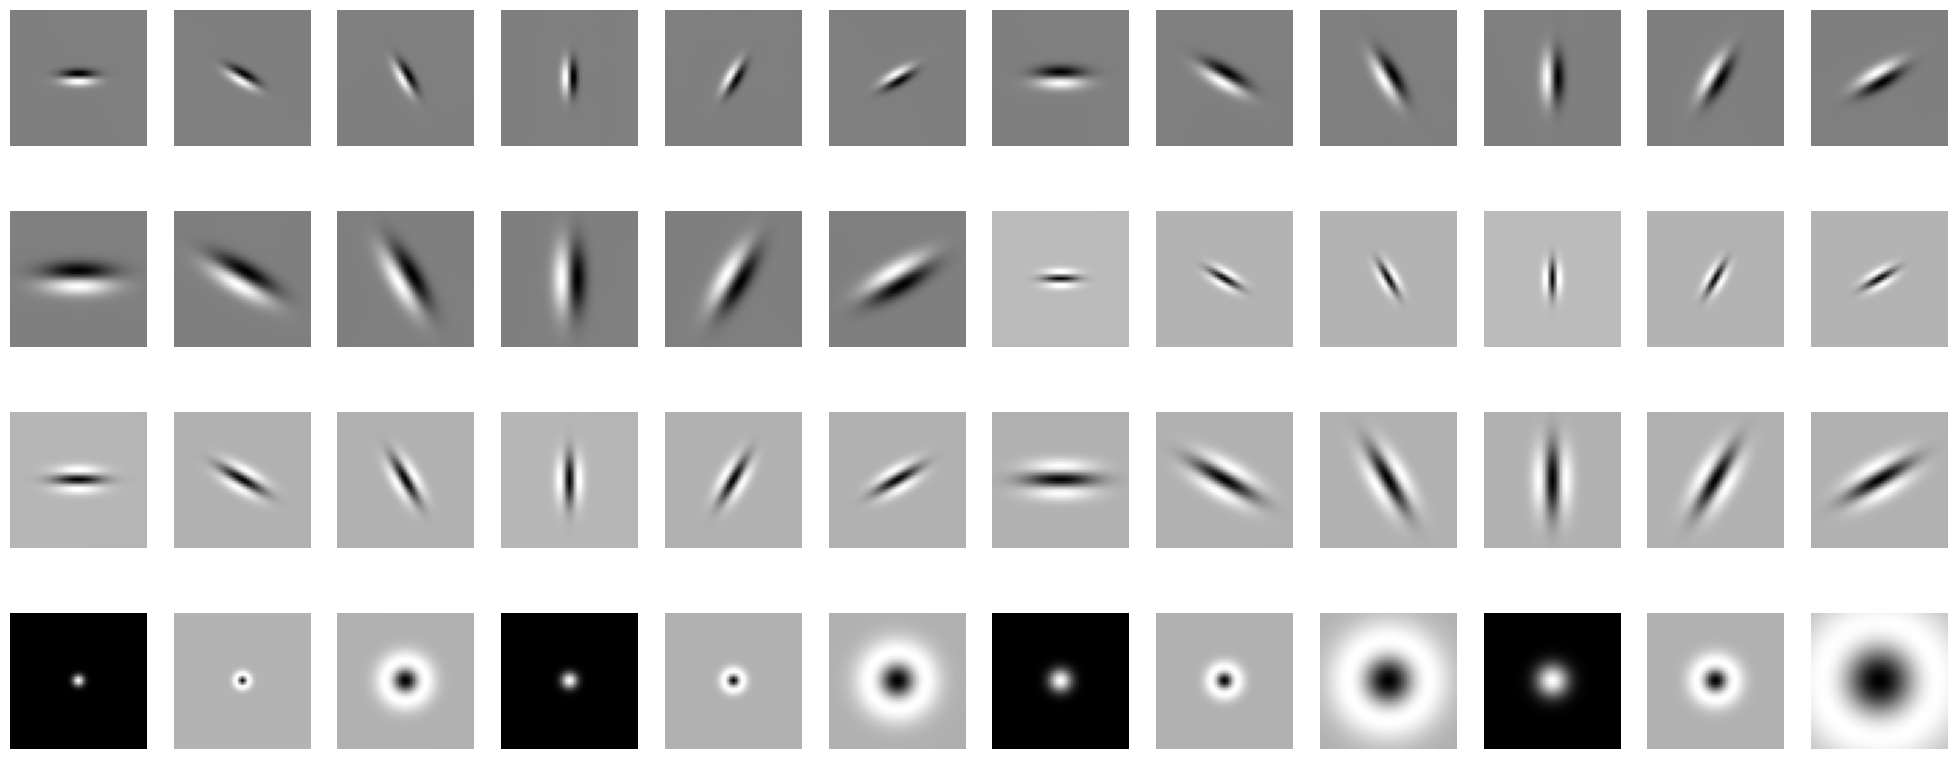

In [113]:
# 保存并可视化第一个卷积层的滤波器
filters = model.conv1.weight.data.squeeze().numpy()
fig, axarr = plt.subplots(4, 12, figsize=(25, 10))
for i in range(4):
    for j in range(12):
        idx = i * 12 + j
        axarr[i][j].imshow(filters[idx], cmap='gray')
        axarr[i][j].axis('off')
plt.savefig('filter_visualization.png')

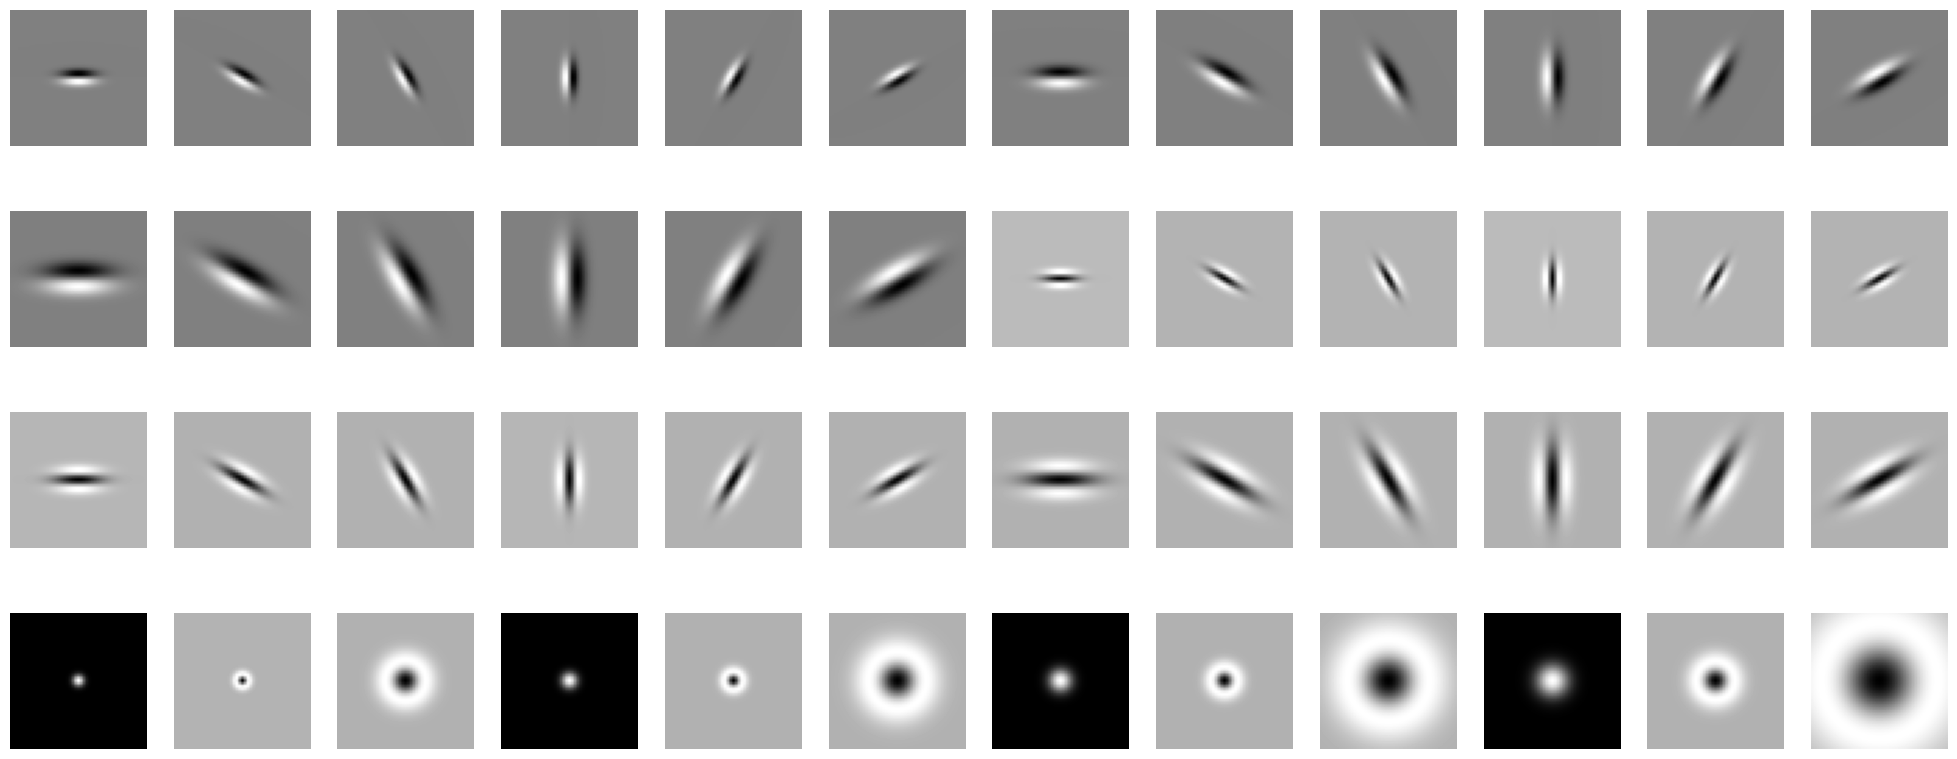

In [114]:
# 可视化原有滤波器对比
fig, axarr = plt.subplots(4, 12, figsize=(25, 10))

for i in range(4):
    for j in range(12):
        idx = i * 12 + j
        axarr[i][j].imshow(F[:,:,idx], cmap='gray')
        axarr[i][j].axis('off')

### 思考题
如果微调后的滤波器分类效果更好的话，可否用在重构任务上？重构的效果会不会更好？如果重构效果更好的话，可否用深度网络实现重构任务？

对于第一个问题，微调Filter Bank CNN后的滤波器在分类任务上效果更好，但是不能保证对于Texton重构任务也会更好。因为这两个任务的目标不同，所以微调后的滤波器可能对Texton重构任务不太适用。因此，需要进行实验来确定微调后的滤波器是否适用于Texton重构任务。

对于第二个问题，使用深度网络进行Texton重构任务是可行的。可以使用卷积神经网络（CNN）或变分自编码器（VAE）等深度学习模型来实现Texton重构任务。这些模型可以从数据中学习到Texton的表示，并且可以通过反向传播算法进行训练。在实践中，使用深度网络进行Texton重构任务是非常常见的。但是需要注意，不同的模型可能在不同的数据集上表现出不同的效果，因此需要根据实际情况选择合适的模型。
